# Forecast-Aware-Global Strategy Analysis

**Strategy**: Forecast-Aware-Global

**Description**: Global variant of forecast-aware strategy. Uses credit balance, carbon multiplier, AND forecast-based trend adjustments with global coordination.

## Key Characteristics:
- Credit balance management with carbon multiplier
- Proactive forecast-based adjustments
- Global coordination across all replicas
- Anticipates carbon intensity changes

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 11

## 1. Load Data

In [94]:
csv_path = "results/simple_20251118_190413/forecast-aware-global/timeseries.csv"
df = pd.read_csv(csv_path)

# make sure precision request columns are numeric and present
for col in ['requests_precision_30', 'requests_precision_50', 'requests_precision_100']:
	if col in df.columns:
		df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)
	else:
		df[col] = 0

# compute requests_total if missing (sum of precision buckets)
if 'requests_total' not in df.columns:
	df['requests_total'] = df['requests_precision_30'] + df['requests_precision_50'] + df['requests_precision_100']

print(f"Loaded {len(df)} samples")
print(f"Time range: {df['elapsed_seconds'].min():.0f}s to {df['elapsed_seconds'].max():.0f}s")
print(f"Total requests: {df['requests_total'].sum():,.0f}")
df.head()

Loaded 119 samples
Time range: 5s to 605s
Total requests: 323,488


,timestamp,elapsed_seconds,delta_requests,mean_precision,credit_balance,credit_velocity,engine_avg_precision,carbon_now,carbon_next,requests_precision_30,...,queue_depth_p50,queue_depth_p100,replicas_router,replicas_consumer,replicas_target,ceiling_router,ceiling_consumer,ceiling_target,throttle_factor,requests_total
0,2025-11-18T19:05:40.710184Z,5.0,2003,0.8908,0.5368,0.0671,0.8870,65.0,70.0,214,...,0,0,0,0,0,NaN,NaN,NaN,0.0,2003
1,2025-11-18T19:05:45.777334Z,10.1,2815,0.8864,0.5993,0.0666,0.8892,70.0,80.0,287,...,0,0,0,0,0,NaN,NaN,NaN,0.0,2815
2,2025-11-18T19:05:50.872980Z,15.2,2601,0.8915,0.6602,0.0660,0.8845,70.0,80.0,253,...,0,0,0,0,0,NaN,NaN,NaN,0.0,2601
3,2025-11-18T19:05:55.926033Z,20.2,2952,0.8916,0.7218,0.0649,0.8866,70.0,80.0,312,...,0,0,0,0,0,NaN,NaN,NaN,0.0,2952
4,2025-11-18T19:06:01.007222Z,25.3,2838,0.8894,0.7850,0.0641,0.8917,80.0,120.0,279,...,0,0,0,0,0,NaN,NaN,NaN,0.0,2838


## 2. Calculate Metrics

In [95]:
df['p30_pct'] = (df['requests_precision_30'] / df['requests_total']) * 100
df['p50_pct'] = (df['requests_precision_50'] / df['requests_total']) * 100
df['p100_pct'] = (df['requests_precision_100'] / df['requests_total']) * 100

df['weighted_precision'] = (
    df['requests_precision_30'] * 0.3 +
    df['requests_precision_50'] * 0.5 +
    df['requests_precision_100'] * 1.0
) / df['requests_total']

print("\n=" * 80)
print("FORECAST-AWARE-GLOBAL STRATEGY SUMMARY")
print("=" * 80)
print(f"\nTotal Requests: {df['requests_total'].sum():,.0f}")
print(f"\nPrecision Distribution:")
print(f"  p30:  {df['requests_precision_30'].sum():>10,.0f} requests ({df['p30_pct'].mean():.1f}% avg)")
print(f"  p50:  {df['requests_precision_50'].sum():>10,.0f} requests ({df['p50_pct'].mean():.1f}% avg)")
print(f"  p100: {df['requests_precision_100'].sum():>10,.0f} requests ({df['p100_pct'].mean():.1f}% avg)")
print(f"\nWeighted Mean Precision: {df['weighted_precision'].mean():.3f}")
print(f"Credit Balance Range: [{df['credit_balance'].min():.3f}, {df['credit_balance'].max():.3f}]")
print(f"Final Credit Balance: {df['credit_balance'].iloc[-1]:.3f}")
print(f"\nCarbon Intensity Range: [{df['carbon_now'].min():.0f}, {df['carbon_now'].max():.0f}] gCO2/kWh")
print(f"Mean Carbon Intensity: {df['carbon_now'].mean():.1f} gCO2/kWh")


=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
FORECAST-AWARE-GLOBAL STRATEGY SUMMARY

Total Requests: 323,488

Precision Distribution:
  p30:      82,591 requests (25.3% avg)
  p50:      66,198 requests (20.3% avg)
  p100:    174,699 requests (54.4% avg)

Weighted Mean Precision: 0.722
Credit Balance Range: [-0.843, 1.000]
Final Credit Balance: 1.000

Carbon Intensity Range: [40, 300] gCO2/kWh
Mean Carbon Intensity: 150.1 gCO2/kWh


## 3. Carbon-Aware Behavior Overview

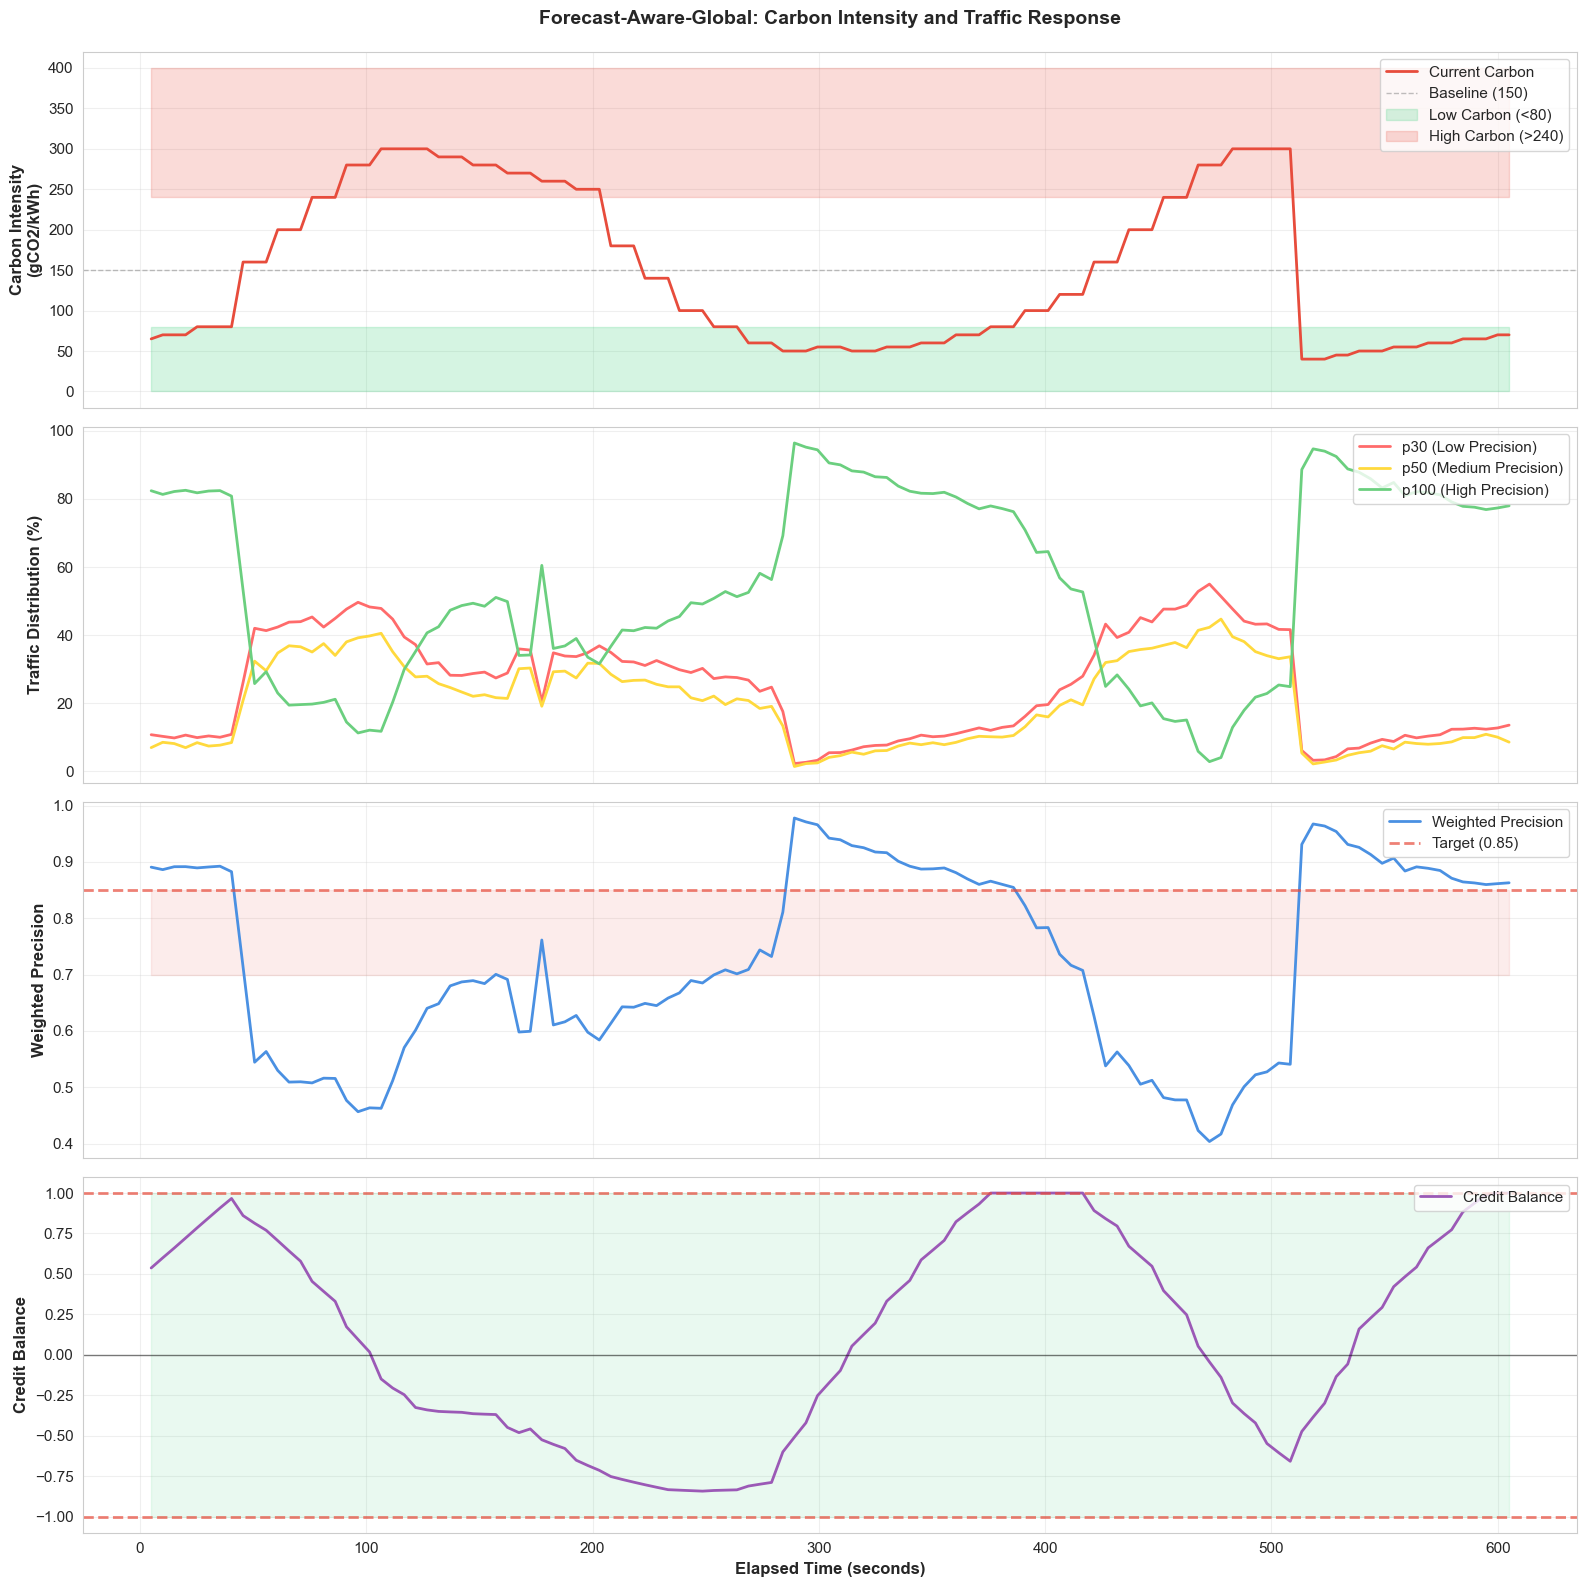

In [96]:
fig, axes = plt.subplots(4, 1, figsize=(16, 16), sharex=True)

axes[0].plot(df['elapsed_seconds'], df['carbon_now'], label='Current Carbon', color='#e74c3c', linewidth=2)
axes[0].axhline(y=150, color='gray', linestyle='--', linewidth=1, label='Baseline (150)', alpha=0.5)
axes[0].fill_between(df['elapsed_seconds'], 0, 80, color='#2ecc71', alpha=0.2, label='Low Carbon (<80)')
axes[0].fill_between(df['elapsed_seconds'], 240, 400, color='#e74c3c', alpha=0.2, label='High Carbon (>240)')
axes[0].set_ylabel('Carbon Intensity\n(gCO2/kWh)', fontsize=12, fontweight='bold')
axes[0].set_title('Forecast-Aware-Global: Carbon Intensity and Traffic Response', fontsize=14, fontweight='bold', pad=20)
axes[0].legend(loc='upper right', fontsize=11)
axes[0].grid(True, alpha=0.3)

axes[1].plot(df['elapsed_seconds'], df['p30_pct'], label='p30 (Low Precision)', color='#ff6b6b', linewidth=2)
axes[1].plot(df['elapsed_seconds'], df['p50_pct'], label='p50 (Medium Precision)', color='#ffd93d', linewidth=2)
axes[1].plot(df['elapsed_seconds'], df['p100_pct'], label='p100 (High Precision)', color='#6bcf7f', linewidth=2)
axes[1].set_ylabel('Traffic Distribution (%)', fontsize=12, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=11)
axes[1].grid(True, alpha=0.3)

axes[2].plot(df['elapsed_seconds'], df['weighted_precision'], label='Weighted Precision', color='#4a90e2', linewidth=2)
axes[2].axhline(y=0.85, color='#e74c3c', linestyle='--', linewidth=2, label='Target (0.85)', alpha=0.7)
axes[2].fill_between(df['elapsed_seconds'], 0.70, 0.85, color='#e74c3c', alpha=0.1)
axes[2].set_ylabel('Weighted Precision', fontsize=12, fontweight='bold')
axes[2].legend(loc='upper right', fontsize=11)
axes[2].grid(True, alpha=0.3)

axes[3].plot(df['elapsed_seconds'], df['credit_balance'], label='Credit Balance', color='#9b59b6', linewidth=2)
axes[3].axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
axes[3].axhline(y=-1.0, color='#e74c3c', linestyle='--', linewidth=2, alpha=0.7)
axes[3].axhline(y=1.0, color='#e74c3c', linestyle='--', linewidth=2, alpha=0.7)
axes[3].fill_between(df['elapsed_seconds'], -1.0, 1.0, color='#2ecc71', alpha=0.1)
axes[3].set_xlabel('Elapsed Time (seconds)', fontsize=12, fontweight='bold')
axes[3].set_ylabel('Credit Balance', fontsize=12, fontweight='bold')
axes[3].legend(loc='upper right', fontsize=11)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Carbon-Aware Swing Analysis


=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
CARBON-AWARE RESPONSE BY CATEGORY
                  p100_pct  p50_pct  p30_pct  weighted_precision  carbon_now  \
carbon_category                                                                
Very Low (<80)        80.3      8.6     11.1                 0.9        61.4   
Low (80-160)          46.4     23.5     30.1                 0.7       130.0   
High (160-240)        23.4     34.3     42.4                 0.5       212.0   
Very High (>240)      29.9     31.6     38.6                 0.6       282.2   

                  credit_balance  
carbon_category                   
Very Low (<80)               0.3  
Low (80-160)                 0.3  
High (160-240)               0.2  
Very High (>240)            -0.4  

📊 CARBON-AWARE SWING ANALYSIS:

Low Carbon (≤80 gCO2/kWh):
  Samples: 54
  Avg p100 usage: 80.3%
  Avg carbon: 61

/var/folders/wy/spr9sjm92894htwcqvd_ps7c0000gn/T/ipykernel_15274/1998712288.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  carbon_response = df.groupby('carbon_category').agg({


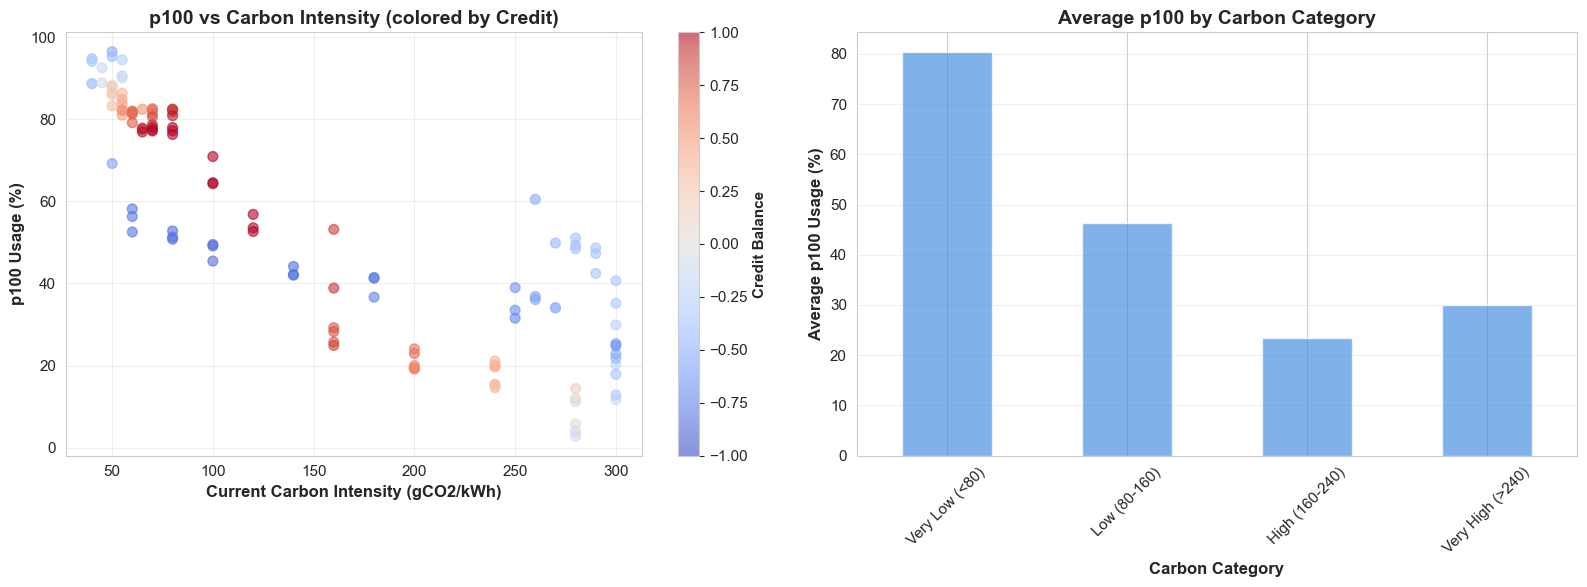

In [97]:
df['carbon_category'] = pd.cut(df['carbon_now'], 
                                bins=[0, 80, 160, 240, 400],
                                labels=['Very Low (<80)', 'Low (80-160)', 'High (160-240)', 'Very High (>240)'])

carbon_response = df.groupby('carbon_category').agg({
    'p100_pct': 'mean',
    'p50_pct': 'mean',
    'p30_pct': 'mean',
    'weighted_precision': 'mean',
    'carbon_now': 'mean',
    'credit_balance': 'mean'
}).round(1)

print("\n=" * 80)
print("CARBON-AWARE RESPONSE BY CATEGORY")
print("=" * 80)
print(carbon_response)

low_carbon = df[df['carbon_now'] <= 80]
high_carbon = df[df['carbon_now'] >= 240]

if len(low_carbon) > 0 and len(high_carbon) > 0:
    p100_swing = low_carbon['p100_pct'].mean() - high_carbon['p100_pct'].mean()
    print(f"\n📊 CARBON-AWARE SWING ANALYSIS:")
    print(f"\nLow Carbon (≤80 gCO2/kWh):")
    print(f"  Samples: {len(low_carbon)}")
    print(f"  Avg p100 usage: {low_carbon['p100_pct'].mean():.1f}%")
    print(f"  Avg carbon: {low_carbon['carbon_now'].mean():.1f} gCO2/kWh")
    print(f"\nHigh Carbon (≥240 gCO2/kWh):")
    print(f"  Samples: {len(high_carbon)}")
    print(f"  Avg p100 usage: {high_carbon['p100_pct'].mean():.1f}%")
    print(f"  Avg carbon: {high_carbon['carbon_now'].mean():.1f} gCO2/kWh")
    print(f"\n🎯 p100 Swing (Low vs High Carbon): {p100_swing:+.1f}pp")
    print()
    if p100_swing >= 20:
        print("✅ STRONG carbon-aware behavior")
    elif p100_swing >= 10:
        print("✓ MODERATE carbon-aware behavior")
    elif p100_swing >= 5:
        print("⚠️  WEAK carbon-aware behavior")
    else:
        print("❌ Little to no carbon-aware behavior")
else:
    print("\n⚠️  Insufficient samples in low/high carbon categories")
    p100_swing = 0

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(df['carbon_now'], df['p100_pct'], alpha=0.6, s=50, 
                c=df['credit_balance'], cmap='coolwarm', vmin=-1, vmax=1)
cbar = plt.colorbar(axes[0].collections[0], ax=axes[0])
cbar.set_label('Credit Balance', fontsize=11, fontweight='bold')
axes[0].set_xlabel('Current Carbon Intensity (gCO2/kWh)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('p100 Usage (%)', fontsize=12, fontweight='bold')
axes[0].set_title('p100 vs Carbon Intensity (colored by Credit)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

carbon_response['p100_pct'].plot(kind='bar', ax=axes[1], color='#4a90e2', alpha=0.7)
axes[1].set_xlabel('Carbon Category', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Average p100 Usage (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Average p100 by Carbon Category', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 5. Forecast Impact Analysis

FORECAST IMPACT ANALYSIS

Forecast Delta Statistics:
  Mean delta: -0.4 gCO2/kWh
  Std dev: 48.5 gCO2/kWh
  Range: -260 to +40 gCO2/kWh

Trend Categories:
  Rising (>+20 gCO2):   25 samples (21.0%)
  Falling (<-20 gCO2):  12 samples (10.1%)
  Stable (-20 to +20):  82 samples (68.9%)

FORECAST-AWARE RESPONSE PATTERNS:

When Carbon is RISING (forecast > current by >20):
  Samples: 25
  Avg current carbon: 171.2 gCO2/kWh
  Avg forecast carbon: 211.2 gCO2/kWh
  Avg forecast delta: +40.0 gCO2/kWh
  → Avg p100 usage: 36.9%
  → Commanded p100: 34.4%
  📈 Strategy INCREASES p100 to use quality NOW before carbon rises

When Carbon is FALLING (forecast < current by >20):
  Samples: 12
  Avg current carbon: 217.5 gCO2/kWh
  Avg forecast carbon: 115.0 gCO2/kWh
  Avg forecast delta: -102.5 gCO2/kWh
  → Avg p100 usage: 35.4%
  → Commanded p100: 35.8%
  📉 Strategy DECREASES p100 to save quality for cleaner future

KEY INSIGHT:
p100 swing between RISING vs FALLING forecasts: +1.5pp

❌ Little to no fore

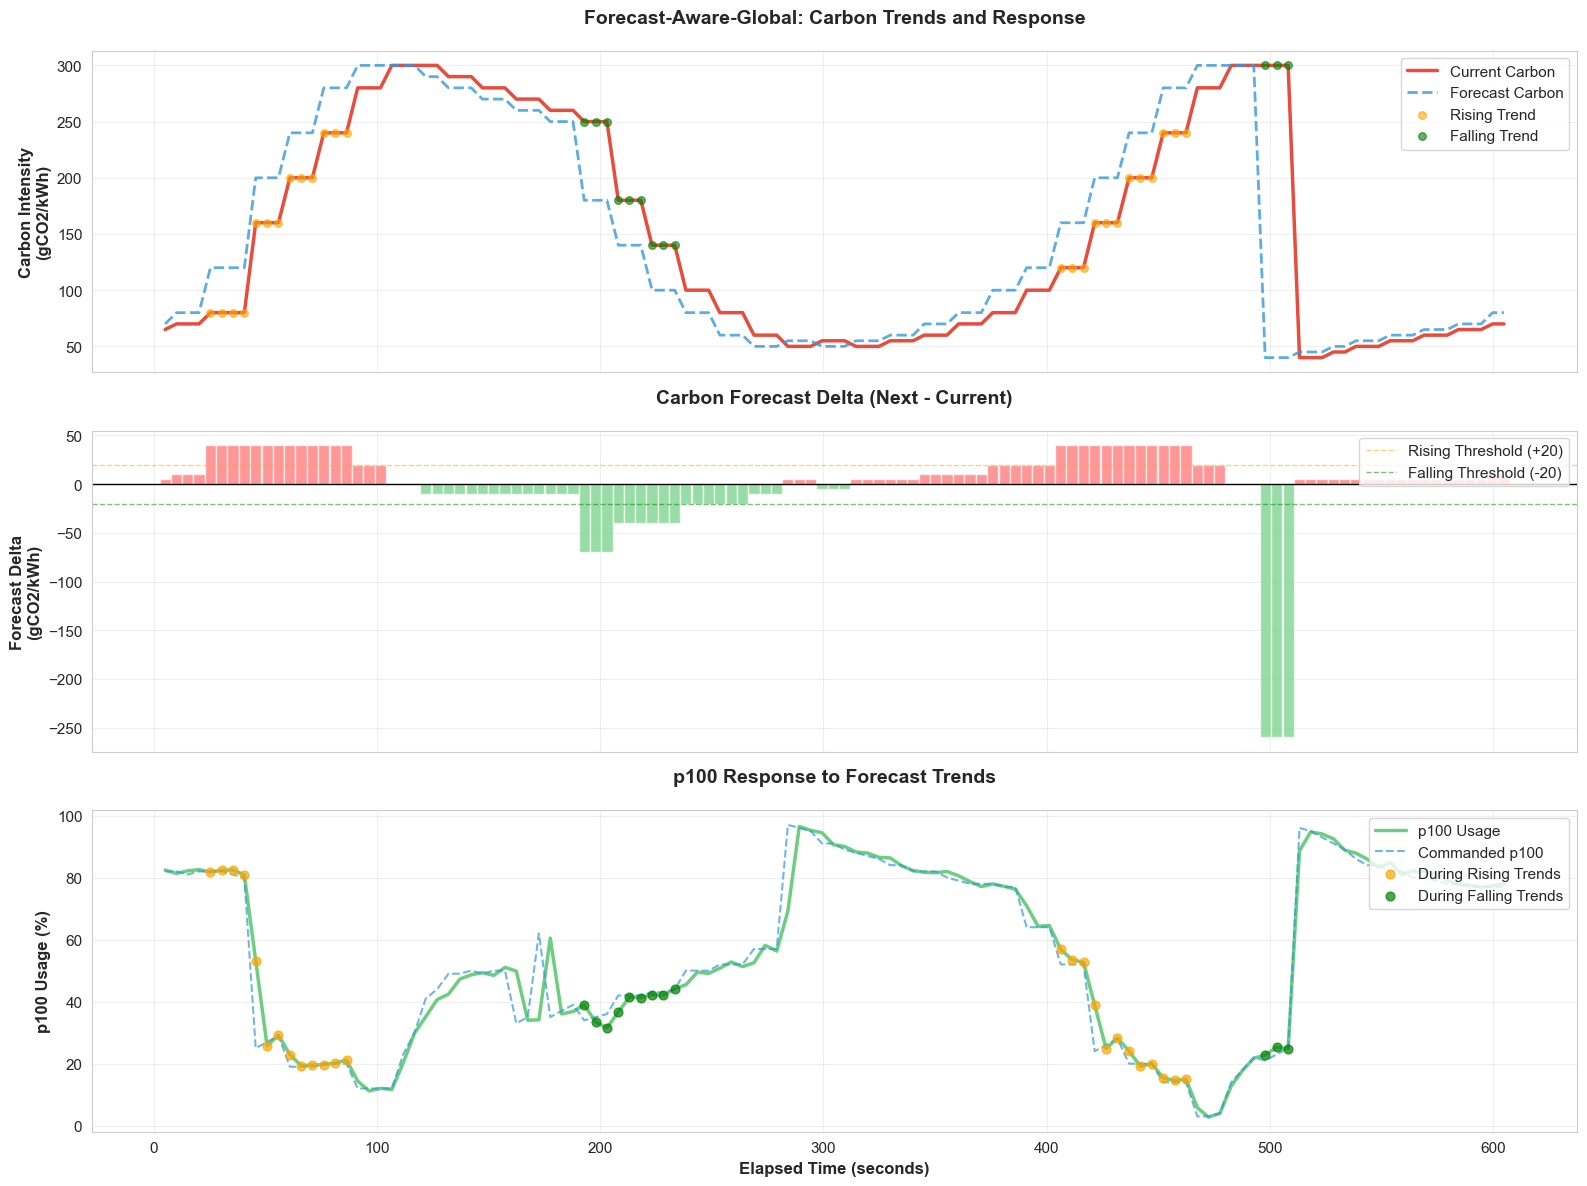

In [98]:
df['carbon_delta'] = df['carbon_next'] - df['carbon_now']
df['carbon_trend'] = df['carbon_delta'].apply(lambda x: 'Rising' if x > 20 else ('Falling' if x < -20 else 'Stable'))

print("=" * 80)
print("FORECAST IMPACT ANALYSIS")
print("=" * 80)
print(f"\nForecast Delta Statistics:")
print(f"  Mean delta: {df['carbon_delta'].mean():+.1f} gCO2/kWh")
print(f"  Std dev: {df['carbon_delta'].std():.1f} gCO2/kWh")
print(f"  Range: {df['carbon_delta'].min():+.0f} to {df['carbon_delta'].max():+.0f} gCO2/kWh")
print()

rising = df[df['carbon_trend'] == 'Rising']
falling = df[df['carbon_trend'] == 'Falling']
stable = df[df['carbon_trend'] == 'Stable']

print("Trend Categories:")
print(f"  Rising (>+20 gCO2):  {len(rising):3d} samples ({len(rising)/len(df)*100:.1f}%)")
print(f"  Falling (<-20 gCO2): {len(falling):3d} samples ({len(falling)/len(df)*100:.1f}%)")
print(f"  Stable (-20 to +20): {len(stable):3d} samples ({len(stable)/len(df)*100:.1f}%)")
print()

if len(rising) > 0 and len(falling) > 0:
    print("=" * 80)
    print("FORECAST-AWARE RESPONSE PATTERNS:")
    print("=" * 80)
    print()
    print(f"When Carbon is RISING (forecast > current by >20):")
    print(f"  Samples: {len(rising)}")
    print(f"  Avg current carbon: {rising['carbon_now'].mean():.1f} gCO2/kWh")
    print(f"  Avg forecast carbon: {rising['carbon_next'].mean():.1f} gCO2/kWh")
    print(f"  Avg forecast delta: +{rising['carbon_delta'].mean():.1f} gCO2/kWh")
    print(f"  → Avg p100 usage: {rising['p100_pct'].mean():.1f}%")
    print(f"  → Commanded p100: {rising['commanded_weight_100'].mean():.1f}%")
    print(f"  📈 Strategy INCREASES p100 to use quality NOW before carbon rises")
    print()
    print(f"When Carbon is FALLING (forecast < current by >20):")
    print(f"  Samples: {len(falling)}")
    print(f"  Avg current carbon: {falling['carbon_now'].mean():.1f} gCO2/kWh")
    print(f"  Avg forecast carbon: {falling['carbon_next'].mean():.1f} gCO2/kWh")
    print(f"  Avg forecast delta: {falling['carbon_delta'].mean():.1f} gCO2/kWh")
    print(f"  → Avg p100 usage: {falling['p100_pct'].mean():.1f}%")
    print(f"  → Commanded p100: {falling['commanded_weight_100'].mean():.1f}%")
    print(f"  📉 Strategy DECREASES p100 to save quality for cleaner future")
    print()
    
    forecast_swing = rising['p100_pct'].mean() - falling['p100_pct'].mean()
    print("=" * 80)
    print("KEY INSIGHT:")
    print("=" * 80)
    print(f"p100 swing between RISING vs FALLING forecasts: {forecast_swing:+.1f}pp")
    print()
    if forecast_swing >= 15:
        print("✅ STRONG forecast-aware behavior - strategy proactively shifts traffic")
        print("   based on predictions, not just reacting to current carbon levels!")
    elif forecast_swing >= 10:
        print("✓ MODERATE forecast-aware behavior detected")
    elif forecast_swing >= 5:
        print("⚠️  WEAK forecast-aware behavior")
    else:
        print("❌ Little to no forecast-aware behavior")
        print()
        print("NOTE: Current carbon may be confounding the forecast effect.")
        print(f"  Rising trends avg current carbon: {rising['carbon_now'].mean():.1f}")
        print(f"  Falling trends avg current carbon: {falling['carbon_now'].mean():.1f}")
        print("  If these differ significantly, the base carbon-aware component")
        print("  may be dominating the forecast adjustment.")
else:
    print("⚠️  Insufficient forecast trend samples for analysis")
    forecast_swing = 0

fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

axes[0].plot(df['elapsed_seconds'], df['carbon_now'], label='Current Carbon', color='#e74c3c', linewidth=2.5)
axes[0].plot(df['elapsed_seconds'], df['carbon_next'], label='Forecast Carbon', color='#3498db', 
             linewidth=2, linestyle='--', alpha=0.8)
rising_mask = df['carbon_trend'] == 'Rising'
falling_mask = df['carbon_trend'] == 'Falling'
axes[0].scatter(df[rising_mask]['elapsed_seconds'], df[rising_mask]['carbon_now'], 
                color='orange', s=30, alpha=0.6, label='Rising Trend', zorder=5)
axes[0].scatter(df[falling_mask]['elapsed_seconds'], df[falling_mask]['carbon_now'], 
                color='green', s=30, alpha=0.6, label='Falling Trend', zorder=5)
axes[0].set_ylabel('Carbon Intensity\n(gCO2/kWh)', fontsize=12, fontweight='bold')
axes[0].set_title('Forecast-Aware-Global: Carbon Trends and Response', fontsize=14, fontweight='bold', pad=20)
axes[0].legend(loc='upper right', fontsize=11)
axes[0].grid(True, alpha=0.3)

axes[1].bar(df['elapsed_seconds'], df['carbon_delta'], width=5, 
            color=df['carbon_delta'].apply(lambda x: '#ff6b6b' if x > 0 else '#6bcf7f'), alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1].axhline(y=20, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='Rising Threshold (+20)')
axes[1].axhline(y=-20, color='green', linestyle='--', linewidth=1, alpha=0.5, label='Falling Threshold (-20)')
axes[1].set_ylabel('Forecast Delta\n(gCO2/kWh)', fontsize=12, fontweight='bold')
axes[1].set_title('Carbon Forecast Delta (Next - Current)', fontsize=14, fontweight='bold', pad=20)
axes[1].legend(loc='upper right', fontsize=11)
axes[1].grid(True, alpha=0.3)

axes[2].plot(df['elapsed_seconds'], df['p100_pct'], label='p100 Usage', color='#6bcf7f', linewidth=2.5)
axes[2].plot(df['elapsed_seconds'], df['commanded_weight_100'], label='Commanded p100', 
             color='#3498db', linewidth=1.5, linestyle='--', alpha=0.7)
axes[2].scatter(df[rising_mask]['elapsed_seconds'], df[rising_mask]['p100_pct'], 
                color='orange', s=40, alpha=0.7, label='During Rising Trends', zorder=5)
axes[2].scatter(df[falling_mask]['elapsed_seconds'], df[falling_mask]['p100_pct'], 
                color='green', s=40, alpha=0.7, label='During Falling Trends', zorder=5)
axes[2].set_xlabel('Elapsed Time (seconds)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('p100 Usage (%)', fontsize=12, fontweight='bold')
axes[2].set_title('p100 Response to Forecast Trends', fontsize=14, fontweight='bold', pad=20)
axes[2].legend(loc='upper right', fontsize=11)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Key Findings Summary

In [99]:
print("=" * 80)
print("KEY FINDINGS: FORECAST-AWARE-GLOBAL STRATEGY")
print("=" * 80)
print()
print("1. OVERALL PERFORMANCE:")
print(f"   - Total requests: {df['requests_total'].sum():,.0f}")
print(f"   - Weighted mean precision: {df['weighted_precision'].mean():.3f}")
print(f"   - Target precision: 0.850")
if df['weighted_precision'].mean() >= 0.85:
    print("   - Status: ✅ AT OR ABOVE TARGET")
elif df['weighted_precision'].mean() >= 0.70:
    print("   - Status: ✓ GOOD (slightly below target, managing credit)")
else:
    print("   - Status: ⚠️  BELOW TARGET")
print()
print("2. CARBON-AWARE BEHAVIOR:")
if len(low_carbon) > 0 and len(high_carbon) > 0:
    print(f"   - p100 at low carbon (≤80): {low_carbon['p100_pct'].mean():.1f}%")
    print(f"   - p100 at high carbon (≥240): {high_carbon['p100_pct'].mean():.1f}%")
    print(f"   - Overall carbon-aware swing: {p100_swing:+.1f}pp")
    if p100_swing >= 20:
        print("   - Status: ✅ STRONG carbon-aware response")
    elif p100_swing >= 10:
        print("   - Status: ✓ MODERATE carbon-aware response")
    else:
        print("   - Status: ⚠️  WEAK carbon-aware response")
else:
    print("   - Status: ⚠️  Insufficient data for carbon-aware analysis")
print()
print("3. FORECAST-AWARE BEHAVIOR:")
if len(rising) > 0 and len(falling) > 0:
    print(f"   - p100 during rising forecasts: {rising['p100_pct'].mean():.1f}%")
    print(f"   - p100 during falling forecasts: {falling['p100_pct'].mean():.1f}%")
    print(f"   - Forecast-aware swing: {forecast_swing:+.1f}pp")
    if forecast_swing >= 15:
        print("   - Status: ✅ STRONG forecast utilization")
    elif forecast_swing >= 10:
        print("   - Status: ✓ MODERATE forecast utilization")
    elif forecast_swing >= 5:
        print("   - Status: ⚠️  WEAK forecast utilization")
    else:
        print("   - Status: ❌ MINIMAL forecast utilization")
        print("   - Note: Forecast component may be too weak compared to base behavior")
else:
    print("   - Status: ⚠️  Insufficient forecast trend samples")
print()
print("4. CREDIT BALANCE:")
print(f"   - Range: [{df['credit_balance'].min():.3f}, {df['credit_balance'].max():.3f}]")
print(f"   - Final: {df['credit_balance'].iloc[-1]:.3f}")
print(f"   - Stability (σ): {df['credit_balance'].std():.3f}")
if df['credit_balance'].min() < -1.0 or df['credit_balance'].max() > 1.0:
    print("   - Status: ❌ EXCEEDED LIMITS (instability)")
elif df['credit_balance'].std() > 0.5:
    print("   - Status: ⚠️  HIGH VARIABILITY")
else:
    print("   - Status: ✅ STABLE within limits")
print()
print("5. GLOBAL COORDINATION:")
print("   - Strategy uses global coordination for all replicas")
print("   - Ensures consistent decision-making across the cluster")
print("   - Compare with local forecast-aware variant for differences")
print()
print("=" * 80)
print("CONCLUSION:")
print("=" * 80)
print()
print("The forecast-aware-global strategy combines:")
print("  1. Base carbon-aware behavior (reacts to CURRENT carbon)")
print("  2. Forecast-based adjustments (anticipates FUTURE carbon)")
print("  3. Global coordination (consistent across all replicas)")
print()
if 'p100_swing' in locals() and 'forecast_swing' in locals():
    print(f"Overall carbon-aware swing: {p100_swing:+.1f}pp")
    print(f"Forecast-specific swing: {forecast_swing:+.1f}pp")
    print()
    if forecast_swing < 5 and p100_swing > 10:
        print("⚠️  NOTE: Base carbon-aware behavior dominates forecast component.")
        print("   Consider tuning forecast parameters (cap, scale) to increase")
        print("   forecast influence. See FORECAST_TUNING_GUIDE.md for details.")
print("=" * 80)

KEY FINDINGS: FORECAST-AWARE-GLOBAL STRATEGY

1. OVERALL PERFORMANCE:
   - Total requests: 323,488
   - Weighted mean precision: 0.722
   - Target precision: 0.850
   - Status: ✓ GOOD (slightly below target, managing credit)

2. CARBON-AWARE BEHAVIOR:
   - p100 at low carbon (≤80): 80.3%
   - p100 at high carbon (≥240): 27.9%
   - Overall carbon-aware swing: +52.4pp
   - Status: ✅ STRONG carbon-aware response

3. FORECAST-AWARE BEHAVIOR:
   - p100 during rising forecasts: 36.9%
   - p100 during falling forecasts: 35.4%
   - Forecast-aware swing: +1.5pp
   - Status: ❌ MINIMAL forecast utilization
   - Note: Forecast component may be too weak compared to base behavior

4. CREDIT BALANCE:
   - Range: [-0.843, 1.000]
   - Final: 1.000
   - Stability (σ): 0.634
   - Status: ⚠️  HIGH VARIABILITY

5. GLOBAL COORDINATION:
   - Strategy uses global coordination for all replicas
   - Ensures consistent decision-making across the cluster
   - Compare with local forecast-aware variant for differen

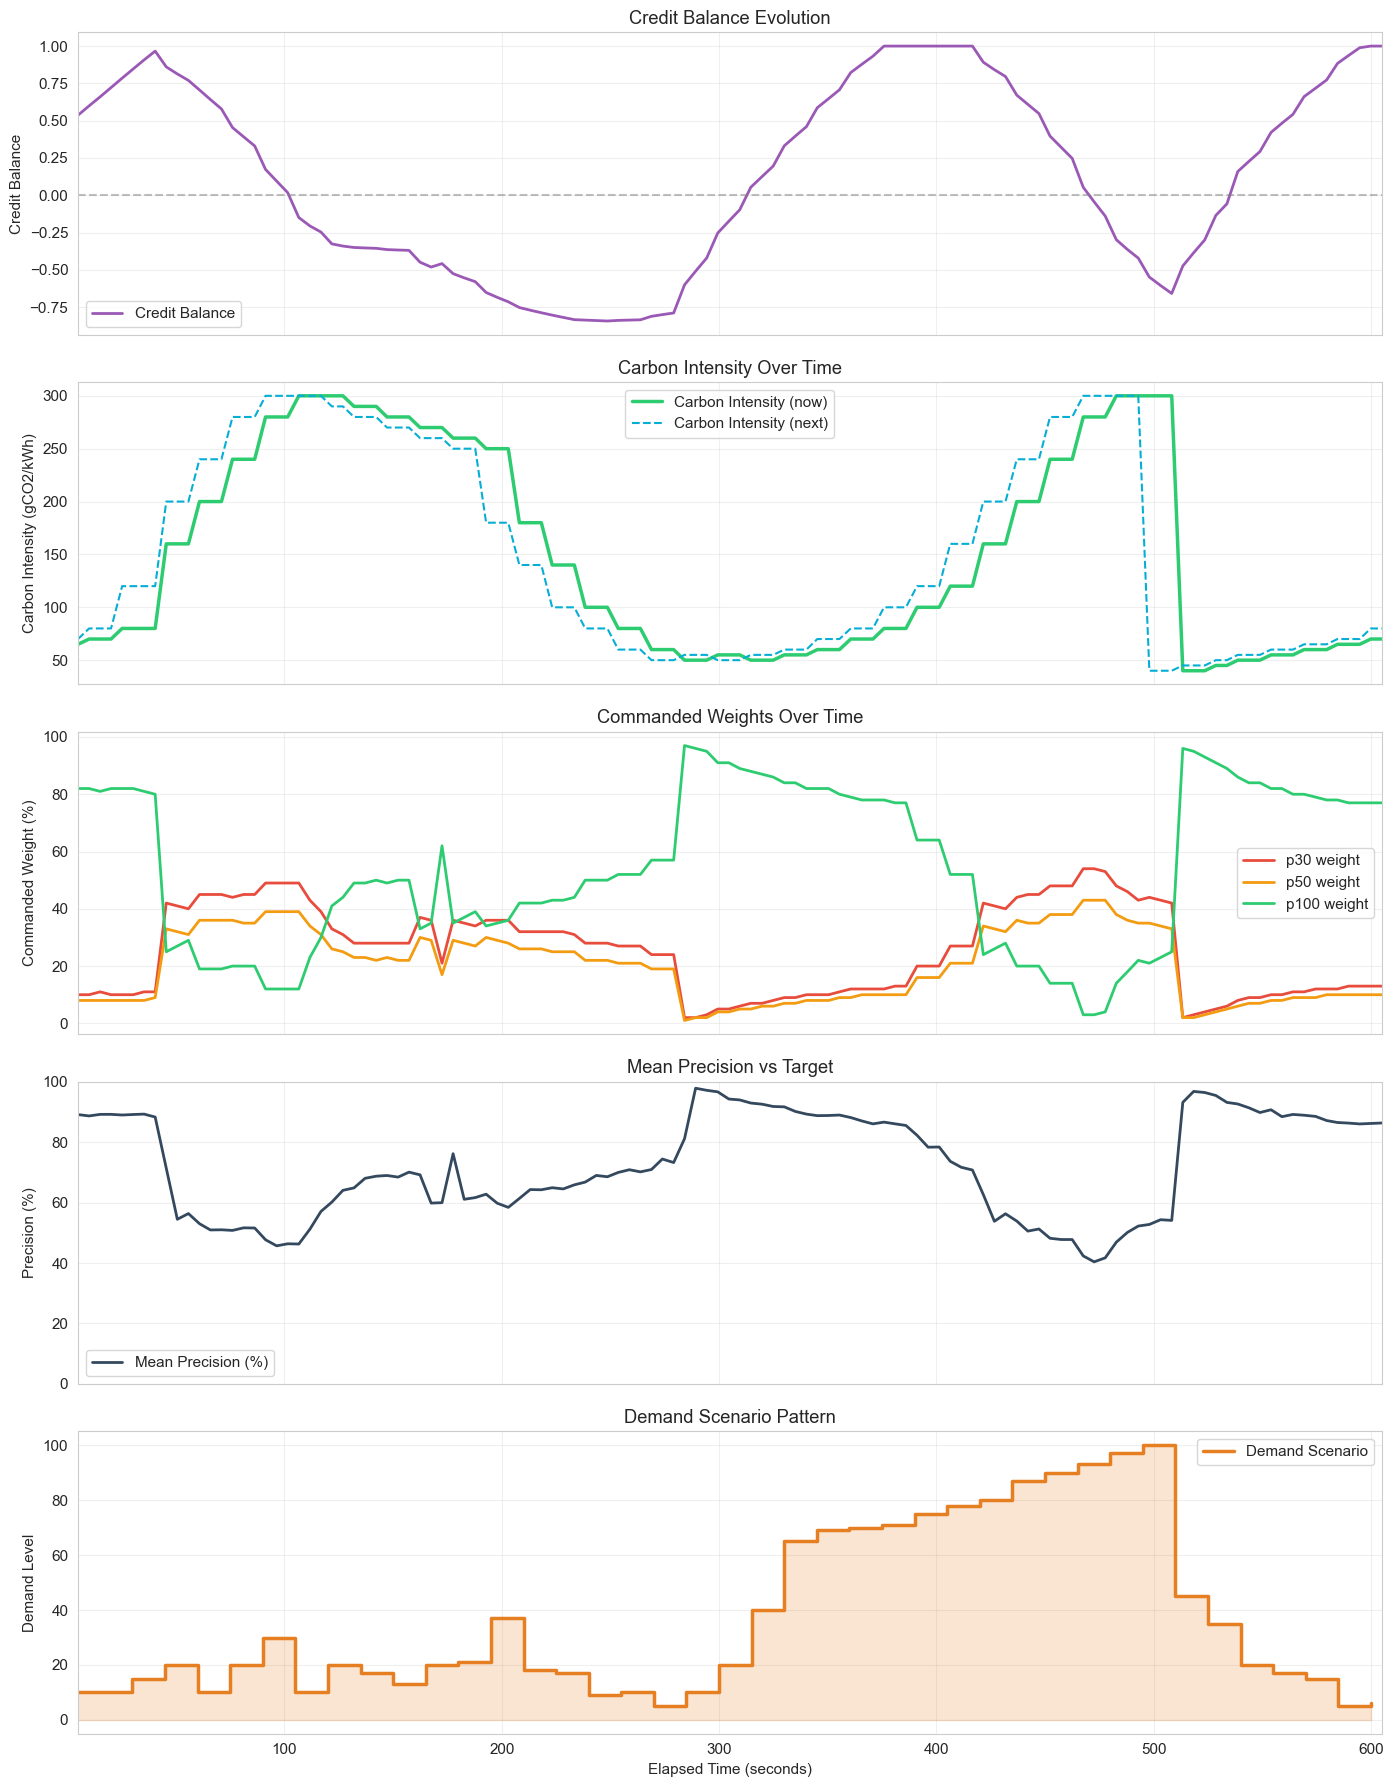

Credit balance range: -0.8429 to 1.0000
Mean credit balance: 0.1197


In [106]:
import json

# Load demand scenario
with open('demand_scenario.json', 'r') as f:
    demand_scenario = json.load(f)

demand_pattern = demand_scenario['pattern']

fig, axes = plt.subplots(5, 1, figsize=(14, 18), sharex=True)

# 1) Credit balance over time
axes[0].plot(df['elapsed_seconds'], df['credit_balance'], linewidth=2, color='#9b59b6', label='Credit Balance')
axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[0].set_ylabel('Credit Balance')
axes[0].set_title('Credit Balance Evolution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2) Carbon intensity main chart
axes[1].plot(df['elapsed_seconds'], df['carbon_now'], linewidth=2.5, color='#2ecc71', label='Carbon Intensity (now)')
if 'carbon_next' in df.columns:
    axes[1].plot(df['elapsed_seconds'], df['carbon_next'], linewidth=1.5, color='#06AED5', linestyle='--', label='Carbon Intensity (next)')
axes[1].set_ylabel('Carbon Intensity (gCO2/kWh)')
axes[1].set_title('Carbon Intensity Over Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3) Commanded weights over time
axes[2].plot(df['elapsed_seconds'], df['commanded_weight_30'], linewidth=2, label='p30 weight', color='#e74c3c')
axes[2].plot(df['elapsed_seconds'], df['commanded_weight_50'], linewidth=2, label='p50 weight', color='#f39c12')
axes[2].plot(df['elapsed_seconds'], df['commanded_weight_100'], linewidth=2, label='p100 weight', color='#2ecc71')
axes[2].set_ylabel('Commanded Weight (%)')
axes[2].set_title('Commanded Weights Over Time')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# 4) Target quality / mean precision over time
# Use 'mean_precision' as actual quality and try to derive target precision from target_error or credit_target if available
if 'mean_precision' in df.columns:
    actual_precision = df['mean_precision']
else:
    # fallback: estimate mean precision from commanded weights and precision tiers
    # Assume p100 -> 1.0, p50 -> 0.5, p30 -> 0.3 to create a proxy
    actual_precision = (df['requests_precision_100'].astype(float) * 1.0 +
                        df['requests_precision_50'].astype(float) * 0.5 +
                        df['requests_precision_30'].astype(float) * 0.3) / df['total_requests']

# Compute a constant target precision if target columns exist
# Decision engine writes target error to 'target_error' or 'credit_target' may exist

target_precision = None
if 'target_error' in df.columns:
    try:
        target_precision = 1.0 - df['target_error'].astype(float)
    except Exception:
        target_precision = None
elif 'credit_target' in df.columns:
    try:
        target_precision = 1.0 - df['credit_target'].astype(float)
    except Exception:
        target_precision = None

# Plot actual mean precision
axes[3].plot(df['elapsed_seconds'], actual_precision * 100, linewidth=2, color='#34495e', label='Mean Precision (%)')

# Plot target precision if available
if target_precision is not None:
    # If target_precision is a series, convert to percent; otherwise plot a constant line
    try:
        unique_vals = sorted(pd.Series(target_precision).unique())
    except Exception:
        unique_vals = []

    if len(unique_vals) == 1:
        axes[3].axhline(y=float(unique_vals[0]) * 100, color='red', linestyle='--', linewidth=2,
                        label=f'Target Precision ({float(unique_vals[0])*100:.0f}%)')
    else:
        axes[3].plot(df['elapsed_seconds'], target_precision * 100, color='red', linestyle='--', linewidth=2, label='Target Precision (%)')

axes[3].set_ylabel('Precision (%)')
axes[3].set_title('Mean Precision vs Target')
axes[3].set_ylim(0, 100)
axes[3].legend()
axes[3].grid(True, alpha=0.3)

# 5) Demand scenario pattern - plot once without cycling
pattern_len = len(demand_pattern)
pattern_duration = 15  # seconds per step
time_points = [i * pattern_duration for i in range(pattern_len)]

axes[4].plot(time_points, demand_pattern, linewidth=2.5, color='#e67e22', label='Demand Scenario', drawstyle='steps-post')
axes[4].fill_between(time_points, 0, demand_pattern, color='#e67e22', alpha=0.2, step='post')
axes[4].set_xlabel('Elapsed Time (seconds)')
axes[4].set_ylabel('Demand Level')
axes[4].set_title('Demand Scenario Pattern')
axes[4].set_xlim(df['elapsed_seconds'].min(), df['elapsed_seconds'].max())
axes[4].legend()
axes[4].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Credit balance range: {df['credit_balance'].min():.4f} to {df['credit_balance'].max():.4f}")
print(f"Mean credit balance: {df['credit_balance'].mean():.4f}")